<a href="https://colab.research.google.com/github/michaelg3709/Causal-Inference/blob/master/Do_why_Sampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade pip
!pip install seaborn==0.9.0
!pip install dowhy

In [0]:
import numpy as np
import pandas as pd
import dowhy.api
import seaborn as sns
import matplotlib.pyplot as pp

%matplotlib inline

In [0]:
sns.set(rc={'figure.figsize':(9, 7)})

## Generating Data


Here, there is no causal relationship between title length and click-through rate. For each population, the click-through rate is independent of title length

In [0]:
N = 100000
n = 30000

# normally, ctr is independent of title_length
title_length = np.random.choice(range(25), size=N) + 1
click_through_rate = np.random.beta(5, 100, size=N)

# but one quirky person prefers titles in a much narrower range, and is especially talented
title_length_2 = np.random.normal(13, 3 ,size=n).astype(int)
click_through_rate_2 = np.random.beta(10, 100, size=n)

# let's concatenate these together
all_title_lengths = np.array(list(title_length) + list(title_length_2))
all_click_rates = np.array(list(click_through_rate) + list(click_through_rate_2))

df = pd.DataFrame({'click_through_rate': all_click_rates, 
                   'title_length': all_title_lengths, 
                   'author': [1]*N + [0]*n})

# restrict down to where there's enough data
df = df[df.title_length > 0][df.title_length < 25]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


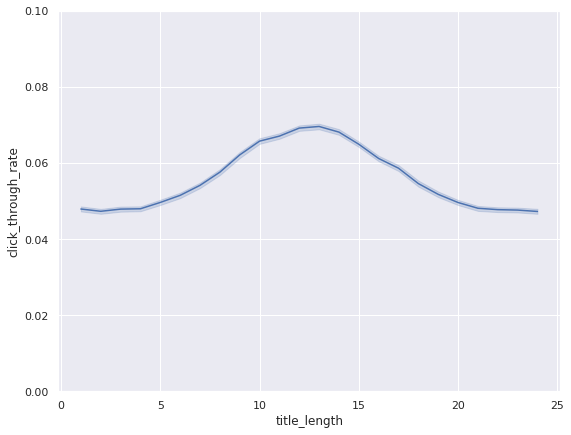

In [0]:
sns.lineplot(data=df, x='title_length', y='click_through_rate'); pp.ylim(0, 0.1)

You can see now the click-through rate depends on the title length! From the data-generating process, we know the dependence isn't causal: it was introduced because one quirky author happened to like 12-16 word titles, and happened to be really good at writing titles. If we were to control for author, this effect would go away, and we'd recover the underlying causal relationship! Let's use the do-sampler to do the adjustment.

In [0]:
causal_df = df.causal.do('title_length', 
                          method='weighting', 
                          variable_types={'title_length': 'd', 
                                          'click_through_rate': 'c', 
                                          'author': 'd'},
                          outcome='click_through_rate',
                          common_causes=['author'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['title_length'] on outcome ['click_through_rate']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'author']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


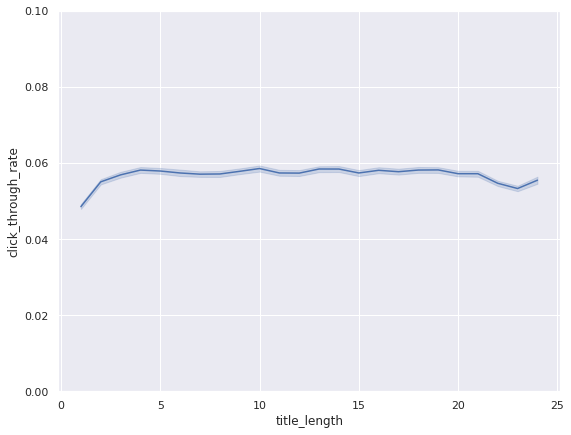

In [0]:
sns.lineplot(data=causal_df, x='title_length', y='click_through_rate'); pp.ylim(0, 0.1)


So we see the bump in the middle goes away! We've recovered the true, underlying causal effect after removing the confounding by our author's title length preference. 